In [17]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import glob
import os
import random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from itertools import combinations

In [18]:
forecast_demand_file_path = '../data/forecastdemand_nsw.csv'
actual_demand_file_path = '../data/totaldemand_nsw.csv'
temperature_file_path = '../data/temperature_nsw.csv'
forecast_demand = pd.read_csv(forecast_demand_file_path)
actual_demand = pd.read_csv(actual_demand_file_path)
temperature = pd.read_csv(temperature_file_path)

Exports_file_path = '../data/Exports - quarterly 2010-2023.csv'
GDP_file_path = '../data/GDP - quarterly 2010-2023.csv'
Interest_file_path = '../data/Interest rate - daily 2011-2023.csv'
SolarInstall_file_path = '../data/Solar installation number - monthly 2007-2023.csv'
SolarOutput_file_path = '../data/Solar outputs - monthly 2015-2023.csv'
Unemployment_file_path = '../data/Unemployment rate - monthly 2010-2023.csv'
Wholesale_file_path = '../data/Wholesale electricity price - half hourly 2014-2023.csv'
cpi_file_path = '../data/inflation-data.xls'
comm_file_path = '../data/Commodity prices index - monthly 2010-2023.csv'
rainfall_file_path = '../data/Rainfall - daily 2010-2023.csv'
weather_file_path = '../data/Weather - daily 2022-2023.csv'
SolarExposure_file_path = '../data/Solar exposure - daily 2010-2023.csv'


In [19]:
cpi = pd.read_excel(cpi_file_path)
Exports = pd.read_csv(Exports_file_path)
GDP = pd.read_csv(GDP_file_path)
Interest = pd.read_csv(Interest_file_path)
SolarInstall = pd.read_csv(SolarInstall_file_path)
SolarOutput = pd.read_csv(SolarOutput_file_path)
Unemployment = pd.read_csv(Unemployment_file_path)
Wholesale = pd.read_csv(Wholesale_file_path)
Comm = pd.read_csv(comm_file_path)
Rainfall = pd.read_csv(rainfall_file_path)
Weather = pd.read_csv(weather_file_path)

In [20]:
lag_value = 0
test_date = '2020-11-30'
temperature.loc[temperature['TEMPERATURE'] <= -5, 'TEMPERATURE'] = np.nan
corr = pd.DataFrame({'Date Time': actual_demand['DATETIME'], 'Total Demand': actual_demand['TOTALDEMAND']})
corr = pd.merge(corr,temperature,left_on=['Date Time'], right_on=['DATETIME'], how = 'left')
corr=corr.drop(columns=['DATETIME', 'LOCATION'])
corr['TEMPERATURE'] = corr['TEMPERATURE'].interpolate(method='linear')
corr['Date Time'] = pd.to_datetime(corr['Date Time'])
forecast_demand['DATETIME'] = pd.to_datetime(forecast_demand['DATETIME'])
actual_demand['DATETIME'] = pd.to_datetime(actual_demand['DATETIME'])
forecast_demand['LASTCHANGED'] = pd.to_datetime(forecast_demand['LASTCHANGED'])
forecast_demand['TIME_DIFF'] = forecast_demand['DATETIME'] - forecast_demand['LASTCHANGED']
forecast_demand = forecast_demand[forecast_demand['TIME_DIFF'] >= pd.Timedelta(hours=6)]
forecast_demand = forecast_demand.drop(columns=['TIME_DIFF'])
fore = forecast_demand.set_index('DATETIME').resample('1H').mean()[['FORECASTDEMAND']]
actu = actual_demand.set_index('DATETIME').resample('1H').mean()[['TOTALDEMAND']]
merged_df = fore.join(actu).dropna()
merged_df['DIFF'] = merged_df.eval('TOTALDEMAND - FORECASTDEMAND')
merged_df['Demand_Previous'] = merged_df['TOTALDEMAND'].shift(periods=(-24))
merged_df['Demand_Lagged'] = merged_df['TOTALDEMAND'].shift(periods=(lag_value))
merged_df['Demand_Rolling'] = merged_df['Demand_Lagged'].rolling(window=168).mean()

temperature['DATETIME'] = pd.to_datetime(temperature['DATETIME'])
temp = temperature.set_index('DATETIME').resample('1H').mean()
temp['TEMPERATURE_lagged'] = temp['TEMPERATURE'].shift(periods=lag_value)
data1 = merged_df.merge(temp, left_index=True, right_index=True, how='inner')
data1 = data1.drop(['LOCATION','TEMPERATURE', 'FORECASTDEMAND', 'DIFF'], axis=1)
corr = data1.dropna()

column_rename_mapping = {
    'G1 CONSUMER PRICE INFLATION': 'DATETIME',
    'Unnamed: 1': 'cpi'
}
cpi = cpi.rename(columns=column_rename_mapping)[10:].dropna().set_index('DATETIME')
min_date, max_date = data1.index.min(), data1.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
cpi.index = pd.to_datetime(cpi.index, format='%b-%Y')
cpi = cpi[(cpi.index >= min_date) & (cpi.index <= max_date)]
cpi = cpi.reindex(date_range).fillna(method='ffill')
cpi['CPI_lagged'] = cpi['cpi'].shift(periods=lag_value)
cpi = cpi[['CPI_lagged']]
corr = pd.concat([corr, cpi], axis=1).dropna()

column_rename_mapping = {
    'Date': 'DATETIME',
    'Exports of goods and services': 'Exports'
}
Exports = Exports.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data1.index.min(), data1.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Exports.index = pd.to_datetime(Exports.index, format='%b-%Y')
Exports = Exports[(Exports.index >= min_date) & (Exports.index <= max_date)]
Exports = Exports.reindex(date_range).fillna(method='ffill')
Exports['Exports_lagged'] = Exports['Exports'].shift(periods=lag_value)
Exports = Exports[['Exports_lagged']]
corr = pd.concat([corr, Exports], axis=1).dropna()

column_rename_mapping = {
    'Date': 'DATETIME',
    'Real GDP': 'GDP'
}
GDP = GDP.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data1.index.min(), data1.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
GDP.index = pd.to_datetime(GDP.index, format='%b-%Y')
GDP = GDP[(GDP.index >= min_date) & (GDP.index <= max_date)]
GDP = GDP.reindex(date_range).fillna(method='ffill')
GDP['GDP_lagged'] = GDP['GDP'].shift(periods=lag_value)
GDP = GDP[['GDP_lagged']]
corr = pd.concat([corr, GDP], axis=1).dropna()

column_rename_mapping = {
    'Date': 'DATETIME',
    'Cash Rate Target': 'Interest'
}
Interest = Interest.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data1.index.min(), data1.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Interest.index = pd.to_datetime(Interest.index)
Interest = Interest[(Interest.index >= min_date) & (Interest.index <= max_date)]
Interest = Interest.reindex(date_range).fillna(method='ffill')
Interest['Interest_lagged'] = Interest['Interest'].shift(periods=lag_value)
Interest = Interest[['Interest_lagged']]
corr = pd.concat([corr, Interest], axis=1).dropna()

column_rename_mapping = {
    "'Month'": 'DATETIME',
    'Cumulative Residential': 'Residential',
    'Cumulative Commercial': 'Commercial'
}
SolarInstall = SolarInstall.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data1.index.min(), data1.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
SolarInstall.index = pd.to_datetime(SolarInstall.index)
SolarInstall = SolarInstall[(SolarInstall.index >= min_date) & (SolarInstall.index <= max_date)]
SolarInstall = SolarInstall.reindex(date_range).fillna(method='ffill')
SolarInstall['Residential_lagged'] = SolarInstall['Residential'].shift(periods=lag_value)
SolarInstall['Commercial_lagged'] = SolarInstall['Commercial'].shift(periods=lag_value)
SolarInstall = SolarInstall[['Residential_lagged','Commercial_lagged']]
corr = pd.concat([corr, SolarInstall], axis=1).dropna()

column_rename_mapping = {
    "Date": 'DATETIME',
    'Output NSW': 'SolarOutput'
}
SolarOutput = SolarOutput.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data1.index.min(), data1.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
SolarOutput.index = pd.to_datetime(SolarOutput.index)
SolarOutput = SolarOutput[(SolarOutput.index >= min_date) & (SolarOutput.index <= max_date)]
SolarOutput = SolarOutput.reindex(date_range).fillna(method='ffill')
SolarOutput['SolarOutput_lagged'] = SolarOutput['SolarOutput'].shift(periods=lag_value)
SolarOutput = SolarOutput[['SolarOutput_lagged']]
corr = pd.concat([corr, SolarOutput], axis=1).dropna()

column_rename_mapping = {
    "Date": 'DATETIME',
    'Unemployment rate': 'Unemployment'
}
Unemployment = Unemployment.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data1.index.min(), data1.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Unemployment.index = pd.to_datetime(Unemployment.index, format='%b-%Y')
Unemployment = Unemployment[(Unemployment.index >= min_date) & (Unemployment.index <= max_date)]
Unemployment = Unemployment.reindex(date_range).fillna(method='ffill')
Unemployment['Unemployment_lagged'] = Unemployment['Unemployment'].shift(periods=lag_value)
Unemployment = Unemployment[['Unemployment_lagged']]
corr = pd.concat([corr, Unemployment], axis=1).dropna()

column_rename_mapping = {
    "SETTLEMENTDATE": 'DATETIME',
    'RRP': 'Price'
}
Wholesale = Wholesale.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data1.index.min(), data1.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Wholesale.index = pd.to_datetime(Wholesale.index, format='%Y/%m/%d %H:%M:%S')
Wholesale = Wholesale[(Wholesale.index >= min_date) & (Wholesale.index <= max_date)]
Wholesale = Wholesale.reindex(date_range).fillna(method='ffill')
Wholesale['Price_lagged'] = Wholesale['Price'].shift(periods=lag_value)
Wholesale = Wholesale[['Price_lagged']]
corr = pd.concat([corr, Wholesale], axis=1).dropna()

column_rename_mapping = {
    "Date": 'DATETIME',
    'Commodity prices ': 'CommPrice'
}
Comm = Comm.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data1.index.min(), data1.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Comm.index = pd.to_datetime(Comm.index, format='%b-%Y')
Comm = Comm[(Comm.index >= min_date) & (Comm.index <= max_date)]
Comm = Comm.reindex(date_range).fillna(method='ffill')
Comm['CommPrice_lagged'] = Comm['CommPrice'].shift(periods=lag_value)
Comm = Comm[['CommPrice_lagged']]
corr = pd.concat([corr, Comm], axis=1).dropna()

# column_rename_mapping = {
#     'Rainfall amount (mm)': 'Rainfall'
# }
# Rainfall = Rainfall.rename(columns=column_rename_mapping).dropna()#.set_index('DATETIME')
# Rainfall['DATETIME'] = pd.to_datetime(Rainfall[['Year', 'Month', 'Day']])
# Rainfall['DATETIME'] -= pd.DateOffset(days=1)
# Rainfall = Rainfall.drop(columns=['Year', 'Month', 'Day'])
# min_datetime, max_datetime = Rainfall['DATETIME'].min(), Rainfall['DATETIME'].max()
# date_range = pd.date_range(start=min_datetime, end=max_datetime, freq='H')
# Rainfall = Rainfall.set_index('DATETIME').reindex(date_range)
# Rainfall['Rainfall'] = Rainfall['Rainfall'].fillna(method='ffill')
# df = pd.concat([df, Rainfall], axis=1).dropna()

# column_rename_mapping = {
#     'Daily global solar exposure (MJ/m*m)': 'SolarExposure'
# }
# SolarExposure = SolarExposure.rename(columns=column_rename_mapping).dropna()#.set_index('DATETIME')
# SolarExposure['DATETIME'] = pd.to_datetime(SolarExposure[['Year', 'Month', 'Day']])
# SolarExposure['DATETIME'] -= pd.DateOffset(days=1)
# SolarExposure = SolarExposure.drop(columns=['Year', 'Month', 'Day'])
# min_datetime, max_datetime = SolarExposure['DATETIME'].min(), SolarExposure['DATETIME'].max()
# date_range = pd.date_range(start=min_datetime, end=max_datetime, freq='H')
# SolarExposure = SolarExposure.set_index('DATETIME').reindex(date_range)
# SolarExposure['SolarExposure'] = SolarExposure['SolarExposure'].fillna(method='ffill')
# df = pd.concat([df, SolarExposure], axis=1).dropna()

corr['HourOfDay'] = corr.index.hour
# day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
corr['DayOfWeek'] = corr.index.dayofweek#.map(day_mapping)
corr['DayOfYear'] = corr.index.dayofyear
corr['IsWeekend'] = np.where((corr['DayOfWeek'] == 5) | (corr['DayOfWeek'] == 6), 1, 0)

In [21]:
lags = range(-24, 0) #Apply hourly lags to the signals

for column in corr.columns:
    if column != 'TOTALDEMAND':
        plt.figure(figsize=(10, 5))
        plt.title(f'{column} Correlations with Lag')
        
        correlations = []
        for lag in lags:
            lagged_df = corr.copy()
            lagged_df[column + f'_lag{lag}'] = corr[column].shift(lag)
            correlation = lagged_df.corr()['TOTALDEMAND'][column + f'_lag{lag}']
            correlations.append(correlation)
        
        plt.bar(lags, correlations, width=0.8, align='center')
        plt.xlabel('Lag')
        plt.ylabel('Correlation')
        plt.grid(axis='y')
        
        plt.savefig(f'{column}_correlation_plot.png')
        plt.close()

In [62]:
cpi = pd.read_excel(cpi_file_path)
Exports = pd.read_csv(Exports_file_path)
GDP = pd.read_csv(GDP_file_path)
Interest = pd.read_csv(Interest_file_path)
SolarInstall = pd.read_csv(SolarInstall_file_path)
SolarOutput = pd.read_csv(SolarOutput_file_path)
Unemployment = pd.read_csv(Unemployment_file_path)
Wholesale = pd.read_csv(Wholesale_file_path)
Comm = pd.read_csv(comm_file_path)
Rainfall = pd.read_csv(rainfall_file_path)
Weather = pd.read_csv(weather_file_path)
SolarExposure = pd.read_csv(SolarExposure_file_path)

In [63]:
### Set lags and test set dates
lag_value = -6
test_date = '2020-11-30'

In [64]:
### Process Signals Into Dataframe

temperature.loc[temperature['TEMPERATURE'] <= -5, 'TEMPERATURE'] = np.nan
df = pd.DataFrame({'Date Time': actual_demand['DATETIME'], 'Total Demand': actual_demand['TOTALDEMAND']})
df = pd.merge(df,temperature,left_on=['Date Time'], right_on=['DATETIME'], how = 'left')
df=df.drop(columns=['DATETIME', 'LOCATION'])
df['TEMPERATURE'] = df['TEMPERATURE'].interpolate(method='linear')
df['Date Time'] = pd.to_datetime(df['Date Time'])
forecast_demand['DATETIME'] = pd.to_datetime(forecast_demand['DATETIME'])
actual_demand['DATETIME'] = pd.to_datetime(actual_demand['DATETIME'])
forecast_demand['DATETIME'] = pd.to_datetime(forecast_demand['DATETIME'])
actual_demand['DATETIME'] = pd.to_datetime(actual_demand['DATETIME'])
fore = forecast_demand.set_index('DATETIME').resample('1H').mean()[['FORECASTDEMAND']]
actu = actual_demand.set_index('DATETIME').resample('1H').mean()[['TOTALDEMAND']]
merged_df = fore.join(actu).dropna()
merged_df['DIFF'] = merged_df.eval('TOTALDEMAND - FORECASTDEMAND')
merged_df['Demand_Previous'] = merged_df['TOTALDEMAND'].shift(periods=(-24))
merged_df['Demand_Lagged'] = merged_df['TOTALDEMAND'].shift(periods=(lag_value))
merged_df['Demand_Rolling'] = merged_df['Demand_Lagged'].rolling(window=720).mean()

temperature['DATETIME'] = pd.to_datetime(temperature['DATETIME'])
temp = temperature.set_index('DATETIME').resample('1H').mean()
temp['TEMPERATURE_lagged'] = temp['TEMPERATURE'].shift(periods=lag_value)
data = merged_df.merge(temp, left_index=True, right_index=True, how='inner')
data = data.drop(['LOCATION','TEMPERATURE', 'FORECASTDEMAND', 'DIFF'], axis=1)
df = data.dropna()

#Process Signals - CPI
column_rename_mapping = {
    'G1 CONSUMER PRICE INFLATION': 'DATETIME',
    'Unnamed: 1': 'cpi'
}
cpi = cpi.rename(columns=column_rename_mapping)[10:].dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
cpi.index = pd.to_datetime(cpi.index, format='%b-%Y')
cpi = cpi[(cpi.index >= min_date) & (cpi.index <= max_date)]
cpi = cpi.reindex(date_range).fillna(method='ffill')
cpi['CPI_lagged'] = cpi['cpi'].shift(periods=lag_value)
cpi = cpi[['CPI_lagged']]
df = pd.concat([df, cpi], axis=1).dropna()

column_rename_mapping = {
    'Date': 'DATETIME',
    'Exports of goods and services': 'Exports'
}
Exports = Exports.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Exports.index = pd.to_datetime(Exports.index, format='%b-%Y')
Exports = Exports[(Exports.index >= min_date) & (Exports.index <= max_date)]
Exports = Exports.reindex(date_range).fillna(method='ffill')
Exports['Exports_lagged'] = Exports['Exports'].shift(periods=lag_value)
Exports = Exports[['Exports_lagged']]
df = pd.concat([df, Exports], axis=1).dropna()

column_rename_mapping = {
    'Date': 'DATETIME',
    'Real GDP': 'GDP'
}
GDP = GDP.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
GDP.index = pd.to_datetime(GDP.index, format='%b-%Y')
GDP = GDP[(GDP.index >= min_date) & (GDP.index <= max_date)]
GDP = GDP.reindex(date_range).fillna(method='ffill')
GDP['GDP_lagged'] = GDP['GDP'].shift(periods=lag_value)
GDP = GDP[['GDP_lagged']]
df = pd.concat([df, GDP], axis=1).dropna()

column_rename_mapping = {
    'Date': 'DATETIME',
    'Cash Rate Target': 'Interest'
}
Interest = Interest.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Interest.index = pd.to_datetime(Interest.index)
Interest = Interest[(Interest.index >= min_date) & (Interest.index <= max_date)]
Interest = Interest.reindex(date_range).fillna(method='ffill')
Interest['Interest_lagged'] = Interest['Interest'].shift(periods=lag_value)
Interest = Interest[['Interest_lagged']]
df = pd.concat([df, Interest], axis=1).dropna()

column_rename_mapping = {
    "'Month'": 'DATETIME',
    'Cumulative Residential': 'Residential',
    'Cumulative Commercial': 'Commercial'
}
SolarInstall = SolarInstall.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
SolarInstall.index = pd.to_datetime(SolarInstall.index)
SolarInstall = SolarInstall[(SolarInstall.index >= min_date) & (SolarInstall.index <= max_date)]
SolarInstall = SolarInstall.reindex(date_range).fillna(method='ffill')
SolarInstall['Residential_lagged'] = SolarInstall['Residential'].shift(periods=lag_value)
SolarInstall['Commercial_lagged'] = SolarInstall['Commercial'].shift(periods=lag_value)
SolarInstall = SolarInstall[['Residential_lagged','Commercial_lagged']]
df = pd.concat([df, SolarInstall], axis=1).dropna()

column_rename_mapping = {
    "Date": 'DATETIME',
    'Output NSW': 'SolarOutput'
}
SolarOutput = SolarOutput.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
SolarOutput.index = pd.to_datetime(SolarOutput.index)
SolarOutput = SolarOutput[(SolarOutput.index >= min_date) & (SolarOutput.index <= max_date)]
SolarOutput = SolarOutput.reindex(date_range).fillna(method='ffill')
SolarOutput['SolarOutput_lagged'] = SolarOutput['SolarOutput'].shift(periods=lag_value)
SolarOutput = SolarOutput[['SolarOutput_lagged']]
df = pd.concat([df, SolarOutput], axis=1).dropna()

column_rename_mapping = {
    "Date": 'DATETIME',
    'Unemployment rate': 'Unemployment'
}
Unemployment = Unemployment.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Unemployment.index = pd.to_datetime(Unemployment.index, format='%b-%Y')
Unemployment = Unemployment[(Unemployment.index >= min_date) & (Unemployment.index <= max_date)]
Unemployment = Unemployment.reindex(date_range).fillna(method='ffill')
Unemployment['Unemployment_lagged'] = Unemployment['Unemployment'].shift(periods=lag_value)
Unemployment = Unemployment[['Unemployment_lagged']]
df = pd.concat([df, Unemployment], axis=1).dropna()

column_rename_mapping = {
    "SETTLEMENTDATE": 'DATETIME',
    'RRP': 'Price'
}
Wholesale = Wholesale.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Wholesale.index = pd.to_datetime(Wholesale.index, format='%Y/%m/%d %H:%M:%S')
Wholesale = Wholesale[(Wholesale.index >= min_date) & (Wholesale.index <= max_date)]
Wholesale = Wholesale.reindex(date_range).fillna(method='ffill')
Wholesale['Price_lagged'] = Wholesale['Price'].shift(periods=lag_value)
Wholesale = Wholesale[['Price_lagged']]
df = pd.concat([df, Wholesale], axis=1).dropna()

column_rename_mapping = {
    "Date": 'DATETIME',
    'Commodity prices ': 'CommPrice'
}
Comm = Comm.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Comm.index = pd.to_datetime(Comm.index, format='%b-%Y')
Comm = Comm[(Comm.index >= min_date) & (Comm.index <= max_date)]
Comm = Comm.reindex(date_range).fillna(method='ffill')
Comm['CommPrice_lagged'] = Comm['CommPrice'].shift(periods=lag_value)
Comm = Comm[['CommPrice_lagged']]
df = pd.concat([df, Comm], axis=1).dropna()

column_rename_mapping = {
    'Rainfall amount (mm)': 'Rainfall'
}
Rainfall = Rainfall.rename(columns=column_rename_mapping).dropna()#.set_index('DATETIME')
Rainfall['DATETIME'] = pd.to_datetime(Rainfall[['Year', 'Month', 'Day']])
Rainfall['DATETIME'] -= pd.DateOffset(days=1)
Rainfall = Rainfall.drop(columns=['Year', 'Month', 'Day'])
min_datetime, max_datetime = Rainfall['DATETIME'].min(), Rainfall['DATETIME'].max()
date_range = pd.date_range(start=min_datetime, end=max_datetime, freq='H')
Rainfall = Rainfall.set_index('DATETIME').reindex(date_range)
Rainfall['Rainfall'] = Rainfall['Rainfall'].fillna(method='ffill')
df = pd.concat([df, Rainfall], axis=1).dropna()

column_rename_mapping = {
    'Daily global solar exposure (MJ/m*m)': 'SolarExposure'
}
SolarExposure = SolarExposure.rename(columns=column_rename_mapping).dropna()#.set_index('DATETIME')
SolarExposure['DATETIME'] = pd.to_datetime(SolarExposure[['Year', 'Month', 'Day']])
SolarExposure['DATETIME'] -= pd.DateOffset(days=1)
SolarExposure = SolarExposure.drop(columns=['Year', 'Month', 'Day'])
min_datetime, max_datetime = SolarExposure['DATETIME'].min(), SolarExposure['DATETIME'].max()
date_range = pd.date_range(start=min_datetime, end=max_datetime, freq='H')
SolarExposure = SolarExposure.set_index('DATETIME').reindex(date_range)
SolarExposure['SolarExposure'] = SolarExposure['SolarExposure'].fillna(method='ffill')
df = pd.concat([df, SolarExposure], axis=1).dropna()

df['HourOfDay'] = df.index.hour
# day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['DayOfWeek'] = df.index.dayofweek#.map(day_mapping)
df['DayOfYear'] = df.index.dayofyear
df['IsWeekend'] = np.where((df['DayOfWeek'] == 5) | (df['DayOfWeek'] == 6), 1, 0)

# data['HourOfDay'] = data.index.hour
# day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
# data['DayOfWeek'] = data.index.dayofweek#.map(day_mapping)
# data['DayOfYear'] = data.index.dayofyear
# data['IsWeekend'] = np.where((data['DayOfWeek'] == 5) | (data['DayOfWeek'] == 6), 1, 0)
# df = pd.get_dummies(df, columns=['HourOfDay'], prefix='Hour')
# df = pd.get_dummies(df, columns=['DayOfWeek'], prefix='Day')
# df = pd.get_dummies(df, columns=['DayOfYear'], prefix='Year')

In [65]:
path = '../data/nswdemand2022onwards'
all_files = glob.glob(os.path.join(path, "*.csv"))

total_demand_2022onwards = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [66]:
To_Z_Score = [
    #'TOTALDEMAND',
 'Demand_Previous',
 'Demand_Lagged',
 'Demand_Rolling',
 'TEMPERATURE_lagged',
 'CPI_lagged',
 'Exports_lagged',
 'GDP_lagged',
 'Interest_lagged',
 'Residential_lagged',
 'Commercial_lagged',
 'SolarOutput_lagged',
 'Unemployment_lagged',
 'Price_lagged',
 'CommPrice_lagged',
'Rainfall',
 'SolarExposure']

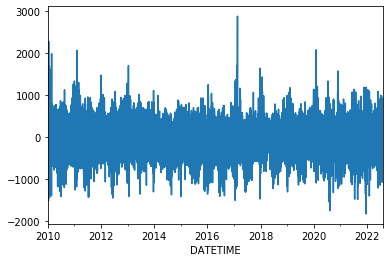

In [67]:
(forecast_demand.set_index('DATETIME').resample('1H').mean()['FORECASTDEMAND'] - actual_demand.set_index('DATETIME').resample('1H').mean()['TOTALDEMAND']).plot()

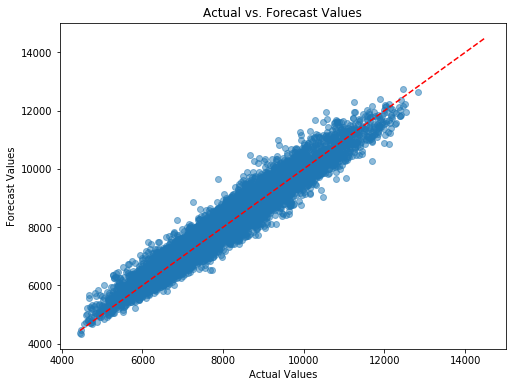

In [68]:
### Plot AEMO predictions vs actual

plt.figure(figsize=(8, 6))
plt.scatter(merged_df['FORECASTDEMAND'].loc[test_date:], merged_df['TOTALDEMAND'].loc[test_date:], alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Forecast Values")
plt.title("Actual vs. Forecast Values")

plt.plot([min(merged_df['FORECASTDEMAND']), max(merged_df['FORECASTDEMAND'])], [min(merged_df['FORECASTDEMAND']), max(merged_df['FORECASTDEMAND'])], color='red', linestyle='--')

plt.show()

In [222]:
### Plot AEMO mse and r^2 

mse = mean_squared_error(merged_df['FORECASTDEMAND'].loc[test_date:], merged_df['TOTALDEMAND'].loc[test_date:])
r2 = r2_score(merged_df['FORECASTDEMAND'].loc[test_date:], merged_df['TOTALDEMAND'].loc[test_date:])

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 96142.73431513214
R-squared: 0.9407544881212608


In [223]:
describe = df.describe()

In [224]:
describe.to_csv('../data/description.csv')

In [71]:
#Include dataframe, target column, columns to normalise, and any columns/features to exclude
def run_regression_model(df, target, norm_columns, exclude_features=[]):
    target_column = 'TOTALDEMAND'
    feature_columns = [col for col in df.columns if col != target_column]
    feature_subset = [col for col in feature_columns if col not in exclude_features]
    
    df = df.dropna()
    # Split the dataset into training and testing sets based on dates
    train_data = df.loc[df.index <= test_date]
    test_data = df.loc[df.index > test_date]

    # Define training and testing features and target
    X_train = train_data[feature_subset]
    y_train = train_data[target_column]

    X_test = test_data[feature_subset]
    y_test = test_data[target_column]
    
    # Fit linear model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    coefficients = model.coef_
    feature_names = X_train.columns

    # Create a DataFrame to display the coefficients and their names
    coef_df = pd.DataFrame({'Coefficient Name': feature_names, 'Coefficient Value': coefficients})
    print(coef_df)
    coef_df.to_csv("../data/models.csv")

    intercept = model.intercept_

    print("Intercept:", intercept)
    
    #Plot the actual vs predictecd values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Values")

    # Add a diagonal line for reference (perfect predictions)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

    plt.show()

Mean Squared Error: 1477074.1310117953
R-squared: 0.06178807742011061
     Coefficient Name  Coefficient Value
0       Demand_Lagged           0.271011
1  TEMPERATURE_lagged         -40.634122
Intercept: 6636.812857651936


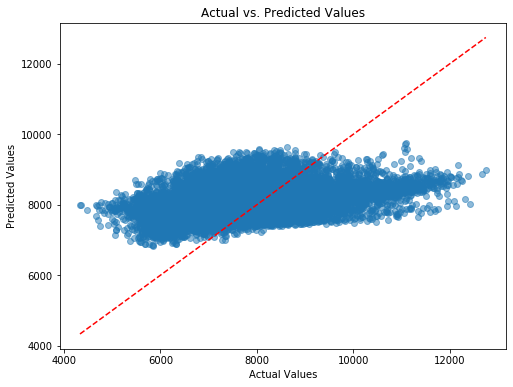

In [75]:
run_regression_model(data, 'TOTALDEMAND', norm_columns = To_Z_Score, exclude_features=['Demand_Previous','Demand_Rolling'])

Mean Squared Error: 370046.59207614814
R-squared: 0.7649528095397085
     Coefficient Name  Coefficient Value
0     Demand_Previous           0.830354
1       Demand_Lagged           0.060311
2      Demand_Rolling           0.132802
3  TEMPERATURE_lagged          -1.852626
Intercept: -159.62044674356002


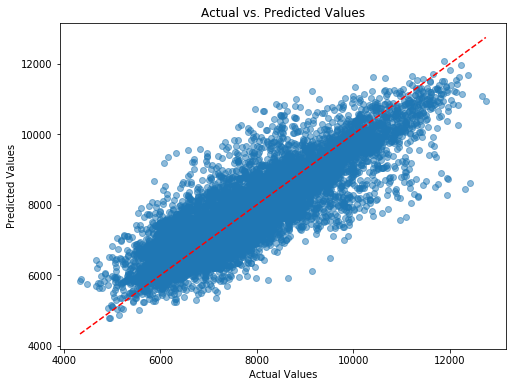

In [80]:
run_regression_model(data, 'TOTALDEMAND', norm_columns = To_Z_Score, exclude_features = ['HourOfDay', 'DayOfWeek', 'DayOfYear', 'IsWeekend'])

Mean Squared Error: 340766.851384767
R-squared: 0.7835507940483696
       Coefficient Name  Coefficient Value
0       Demand_Previous       6.893793e-01
1         Demand_Lagged       1.112147e-01
2        Demand_Rolling       2.270412e-01
3    TEMPERATURE_lagged       7.285654e+00
4            CPI_lagged       6.835361e+00
5        Exports_lagged      -1.605258e-10
6            GDP_lagged       1.390236e-09
7       Interest_lagged       9.089048e+00
8    Residential_lagged       6.129499e-05
9     Commercial_lagged       3.023441e-06
10   SolarOutput_lagged      -5.083963e-04
11  Unemployment_lagged       2.525183e+01
12         Price_lagged       4.753400e-02
13     CommPrice_lagged      -2.248215e+00
14            HourOfDay       3.747137e+01
15            DayOfWeek       6.444285e+01
16            DayOfYear       1.668560e-01
17            IsWeekend      -6.025021e+02
Intercept: -2289.1060431386295


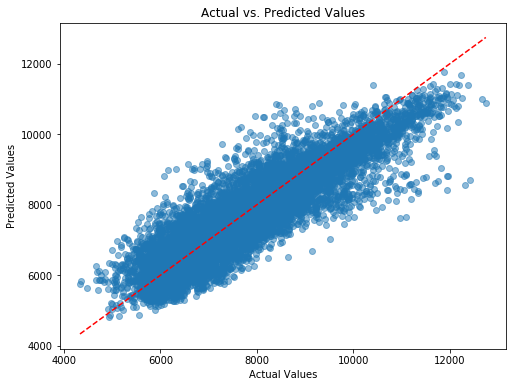

In [82]:
run_regression_model(df, 'TOTALDEMAND', norm_columns = To_Z_Score, exclude_features = ['Rainfall','SolarExposure'])

In [83]:
#Include dataframe, target column, columns to normalise, any columns/features to exclude, hyperparamters,
def run_xdg_model(df, target, norm_columns, exclude_features=[], n_estimators=1500, seed = 42, max_depth = 6, importance = False):
    #Select feature columns to include
    feature_columns = [col for col in df.columns if col != target]
    feature_subset = [col for col in feature_columns if col not in exclude_features]

    keys = list(df.keys())
    #Choose columns to normalise
    norm_columns = [x for x in keys if x in norm_columns]

    df = df.dropna()
    #Split Data on test date
    train_data = df.loc[df.index <= test_date].copy()
    test_data = df.loc[df.index > test_date].copy()

    scaler = StandardScaler()
    train_data.loc[:, norm_columns] = scaler.fit_transform(train_data.loc[:, norm_columns])
    test_data.loc[:, norm_columns] = scaler.transform(test_data.loc[:, norm_columns])

    X_train, y_train = train_data[feature_subset], train_data[target]
    X_test, y_test = test_data[feature_subset], test_data[target]
    # Select model on hyper parameters n_estimators, random_state, max_depth
    xgb_model = XGBRegressor(n_estimators=n_estimators, random_state=seed, max_depth= max_depth)
    # Fit the model
    xgb_model.fit(X_train, y_train)
    # Generate Predictions
    y_pred = xgb_model.predict(X_test)
    # Measures of performance
    mse, r2 = mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")
    #Plot the prediction vs actual values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Values")

    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

    plt.show()
    if importance == True:
        #Optional plot the feature importance
        plt.figure(figsize=(14, 10))
        plt.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
        plt.xticks(range(len(feature_subset)), feature_subset, rotation=45)
        plt.show()
    
    return r2

In [ ]:
run_xdg_model(data, 'TOTALDEMAND', norm_columns = ['Demand_Lagged', 'TEMPERATURE_lagged'], exclude_features=['Demand_Previous','Demand_Rolling','HourOfDay','DayOfWeek','DayOfYear','IsWeekend'], n_estimators=1500)

In [ ]:
run_xdg_model(data, 'TOTALDEMAND', norm_columns = To_Z_Score, exclude_features =['HourOfDay','DayOfWeek','DayOfYear','IsWeekend'], n_estimators=1500)

Depth:  6  Estimators:  2500
Mean Squared Error: 446400.98244173307
R-squared: 0.7164538223336705


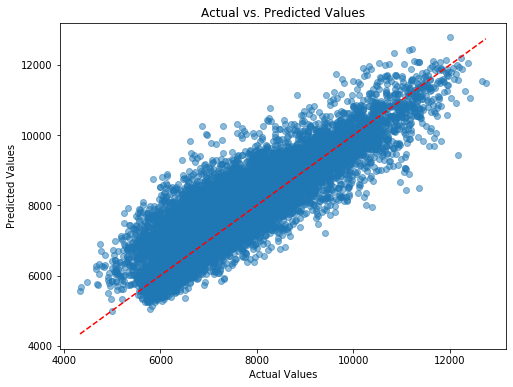

Depth:  12  Estimators:  2500
Mean Squared Error: 269287.0484244251
R-squared: 0.8289535277047472


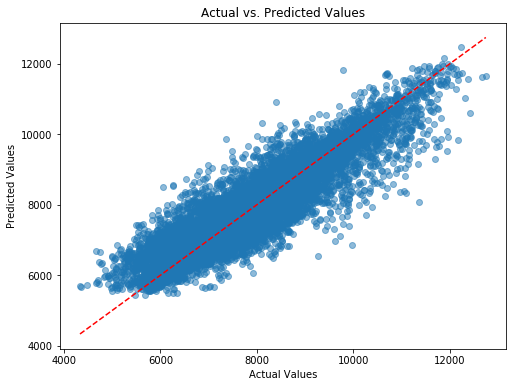

Depth:  18  Estimators:  2500
Mean Squared Error: 301327.1039378566
R-squared: 0.8086022389970967


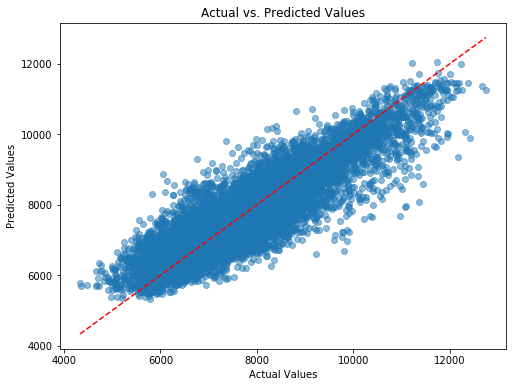

Depth:  6  Estimators:  5000
Mean Squared Error: 450344.38894916745
R-squared: 0.713949038773268


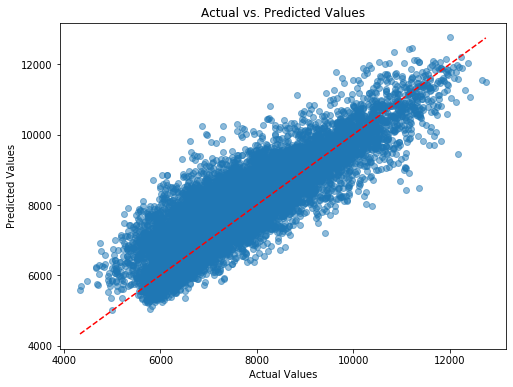

Depth:  12  Estimators:  5000
Mean Squared Error: 269288.2551615052
R-squared: 0.8289527612062404


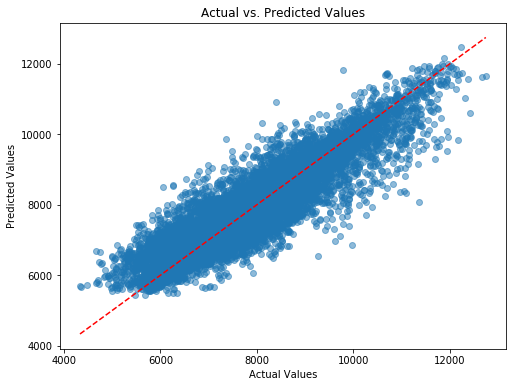

Depth:  18  Estimators:  5000
Mean Squared Error: 301325.8848055282
R-squared: 0.8086030133688509


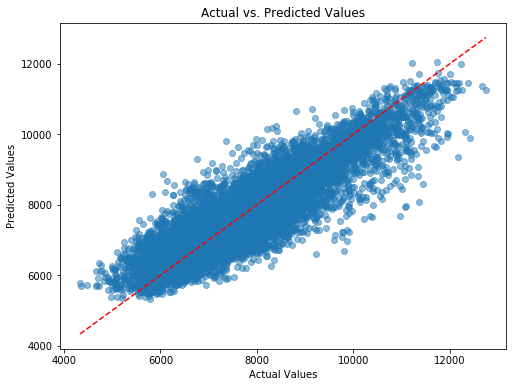

Depth:  6  Estimators:  7500
Mean Squared Error: 451080.27188398613
R-squared: 0.7134816186698525


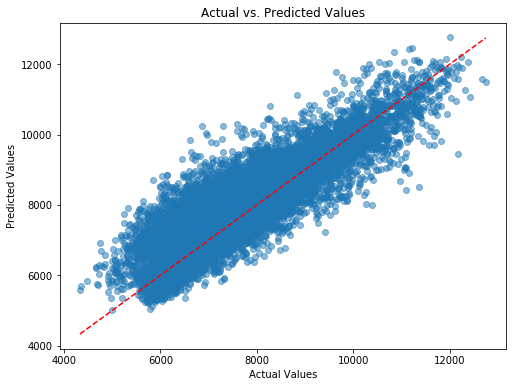

Depth:  12  Estimators:  7500
Mean Squared Error: 269289.4635615453
R-squared: 0.82895199365145


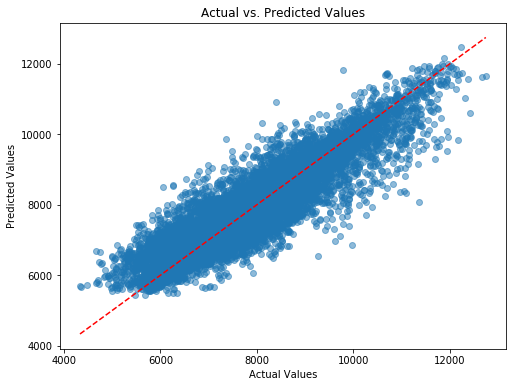

Depth:  18  Estimators:  7500
Mean Squared Error: 301324.66837550973
R-squared: 0.8086037860241444


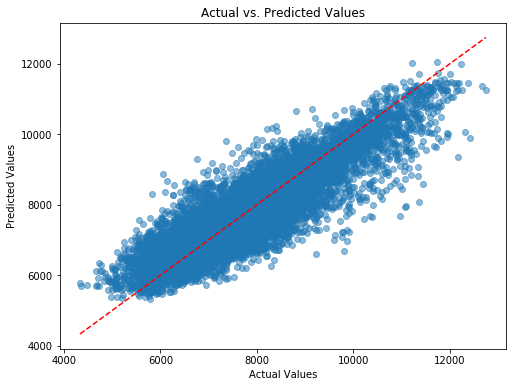

Depth:  6  Estimators:  10000
Mean Squared Error: 451097.7086759588
R-squared: 0.7134705431213902


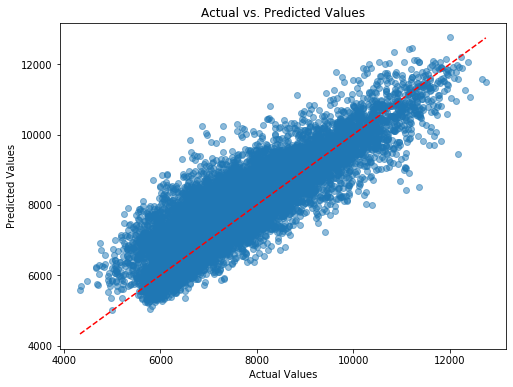

Depth:  12  Estimators:  10000


KeyboardInterrupt: 

In [234]:
#Adjust basic hyperparameters for the model
for estimators in range(2500, 12500, 2500):
    for depth in range(6,24,6):
        print('Depth: ', depth, " Estimators: ", estimators)
        run_xdg_model(df, 'TOTALDEMAND', norm_columns = To_Z_Score, n_estimators=estimators, max_depth = depth)

Mean Squared Error: 418117.21643173206
Root Mean Squared Error: 646.6198391881678
R-squared: 0.7344191809632102


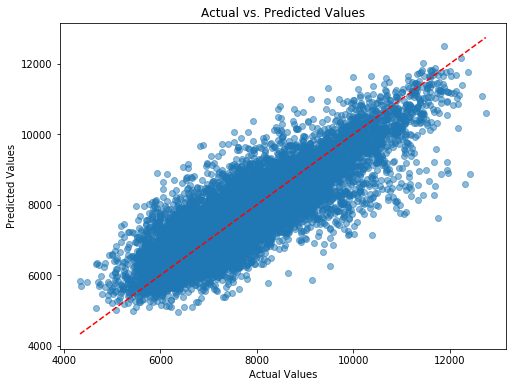

0.7344191809632102

In [121]:
run_xdg_model(df, 'TOTALDEMAND', norm_columns = To_Z_Score, exclude_features= [
#                                                                                'CPI_lagged', 'Interest_lagged', 'CommPrice_lagged', 
#                                                                                'Exports_lagged', 'GDP_lagged',
#                                                                                'Residential_lagged', 'Commercial_lagged', 
#                                                                                 'SolarOutput_lagged',
#                                                                                'Unemployment_lagged', 'Price_lagged', 
#                                                                                 'Rainfall'
                                                                              ], n_estimators=2500, max_depth=12)

Mean Squared Error: 250603.26892407096
R-squared: 0.840821141061484


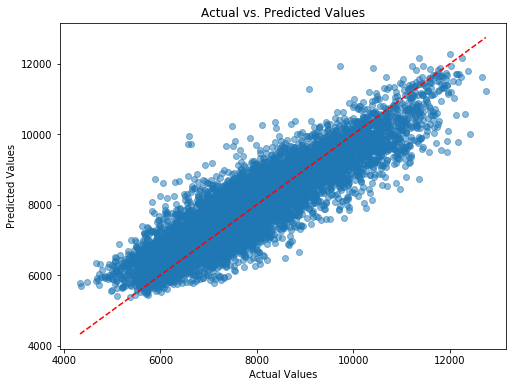

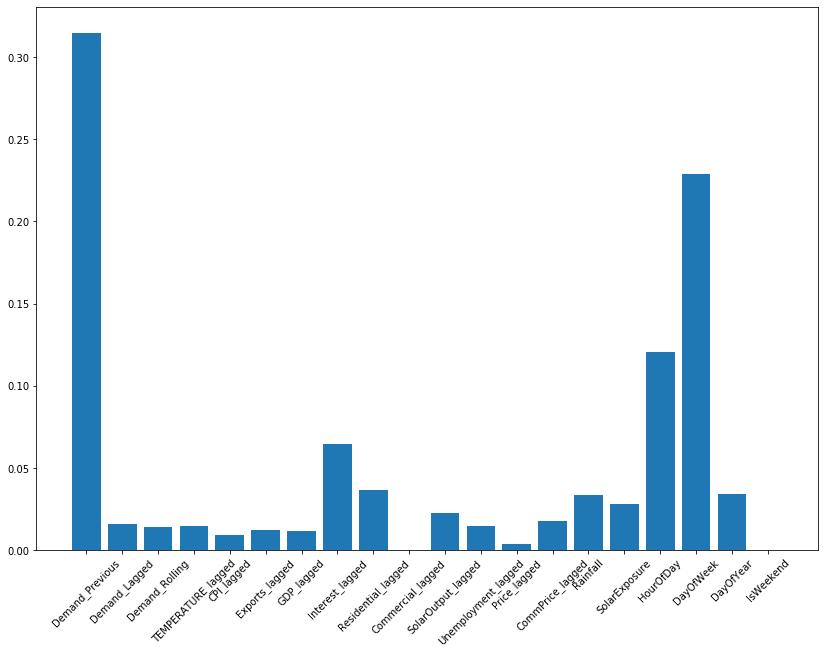

0.840821141061484

In [55]:
run_xdg_model(df,'TOTALDEMAND', norm_columns = To_Z_Score, n_estimators=3000, exclude_features= [
                                                                              ], max_depth=12, importance=True)

TOTALDEMAND
Mean Squared Error: 250603.26892407096
R-squared: 0.840821141061484


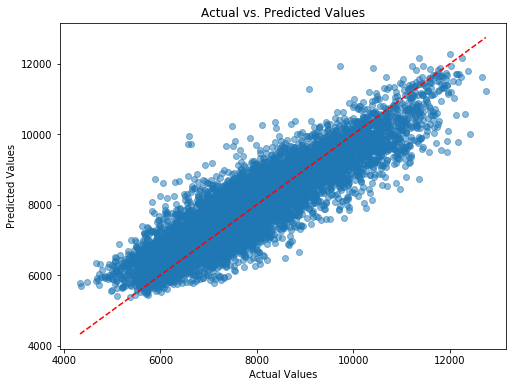

Demand_Previous
Mean Squared Error: 335122.5862664819
R-squared: 0.7871359335596474


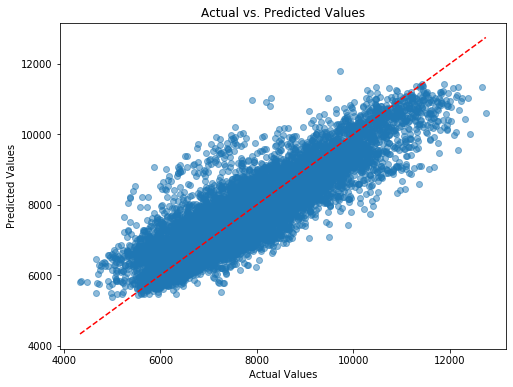

Demand_Lagged
Mean Squared Error: 334776.0642091991
R-squared: 0.7873560383727735


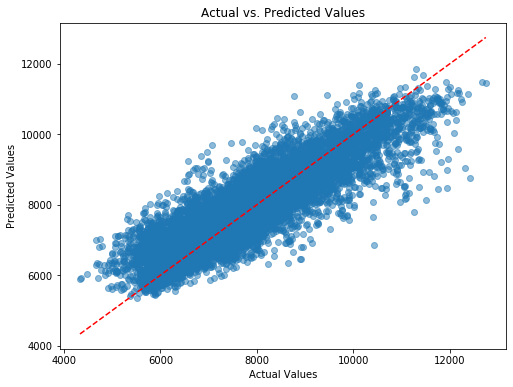

Demand_Rolling
Mean Squared Error: 299654.56482319103
R-squared: 0.8096646068941539


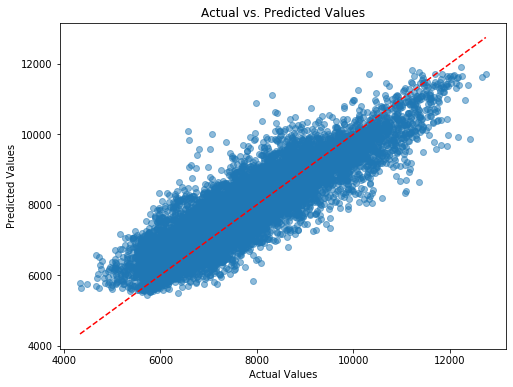

TEMPERATURE_lagged
Mean Squared Error: 288074.0975779324
R-squared: 0.8170203192517355


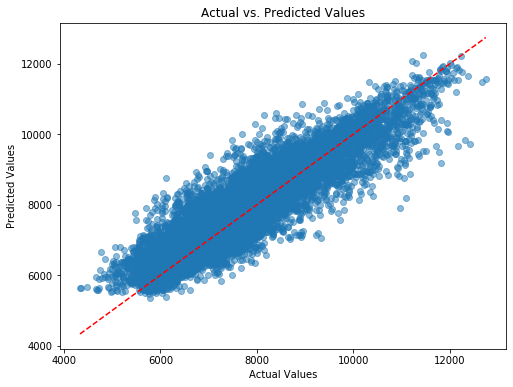

CPI_lagged
Mean Squared Error: 245427.3420035762
R-squared: 0.844108800255599


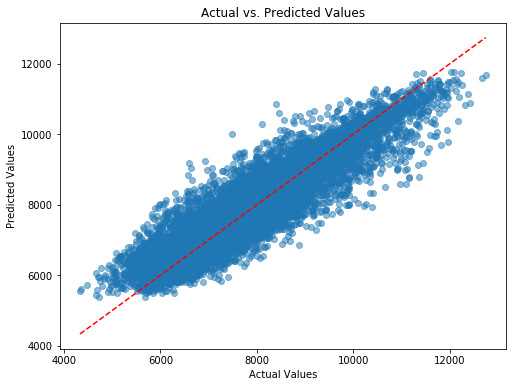

Exports_lagged
Mean Squared Error: 268815.6290937421
R-squared: 0.8292529651041948


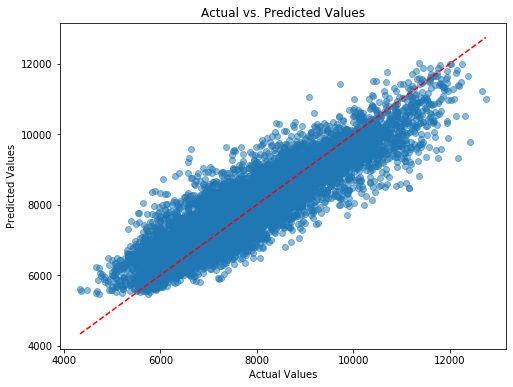

GDP_lagged
Mean Squared Error: 253153.7570594301
R-squared: 0.8392011151421666


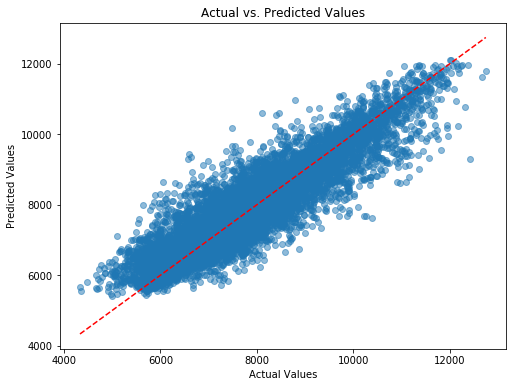

Interest_lagged
Mean Squared Error: 257332.37314813735
R-squared: 0.8365469305267852


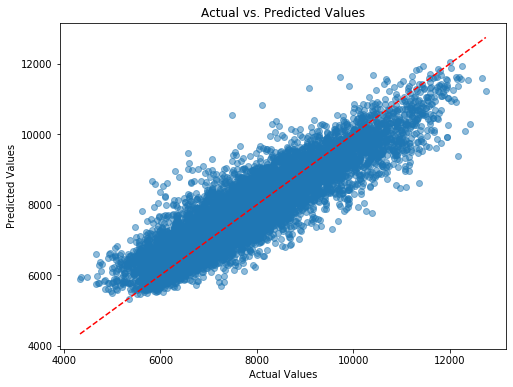

Residential_lagged
Mean Squared Error: 250603.26892407096
R-squared: 0.840821141061484


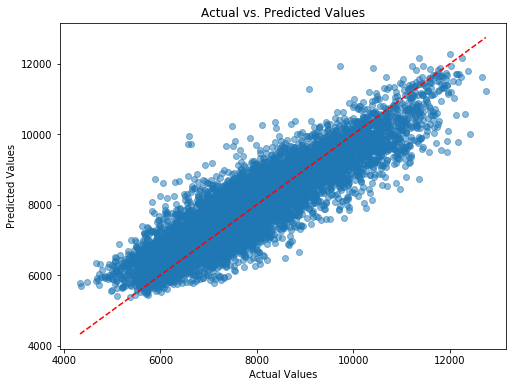

Commercial_lagged
Mean Squared Error: 250603.26892407096
R-squared: 0.840821141061484


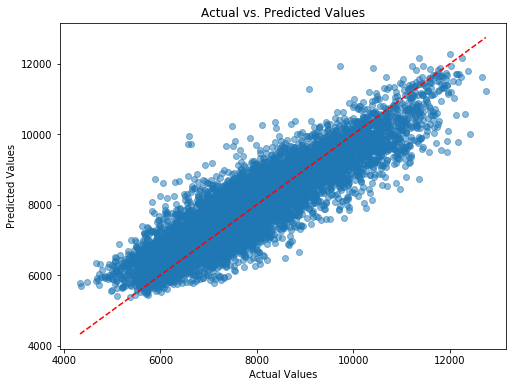

SolarOutput_lagged
Mean Squared Error: 255570.0741323966
R-squared: 0.8376663123594262


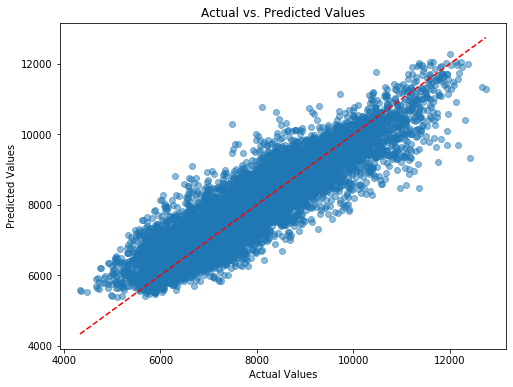

Unemployment_lagged
Mean Squared Error: 254872.6506945853
R-squared: 0.8381093036560059


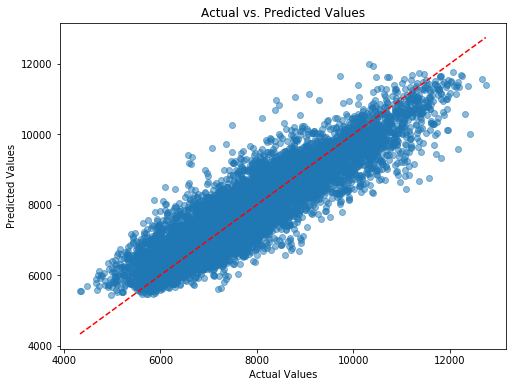

Price_lagged
Mean Squared Error: 255954.90416118412
R-squared: 0.8374218749858411


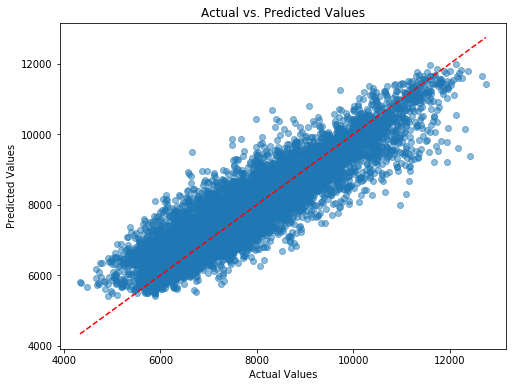

CommPrice_lagged
Mean Squared Error: 257535.07879891855
R-squared: 0.8364181754058713


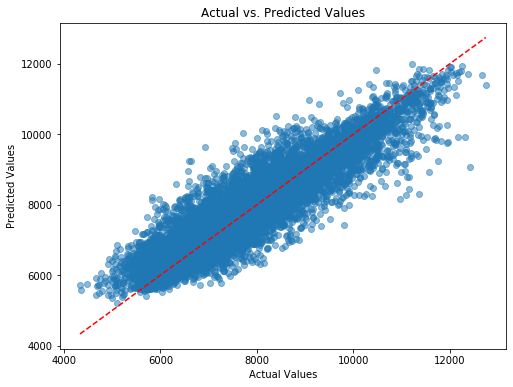

Rainfall
Mean Squared Error: 282102.0872007686
R-squared: 0.820813636878785


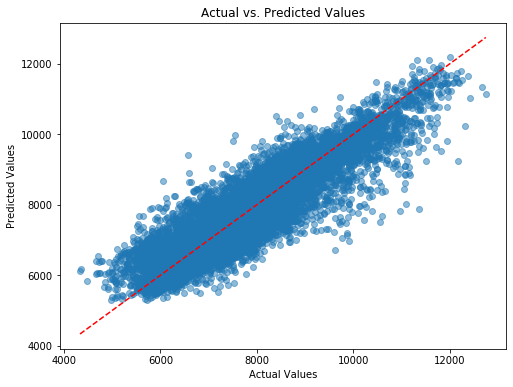

SolarExposure
Mean Squared Error: 263164.52881439344
R-squared: 0.8328424461914762


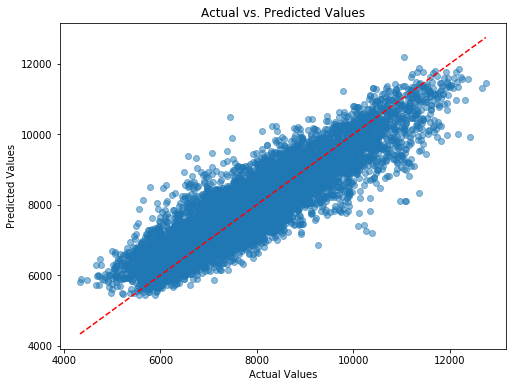

HourOfDay
Mean Squared Error: 406578.5812623764
R-squared: 0.7417483223102146


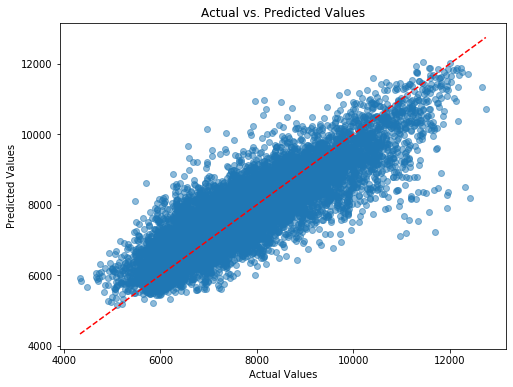

DayOfWeek
Mean Squared Error: 281762.86200351507
R-squared: 0.8210291068527156


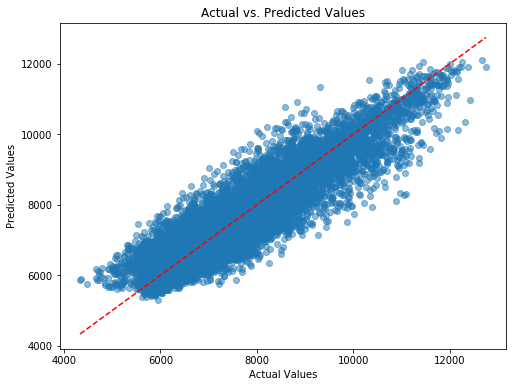

DayOfYear
Mean Squared Error: 291117.2286236894
R-squared: 0.8150873750824766


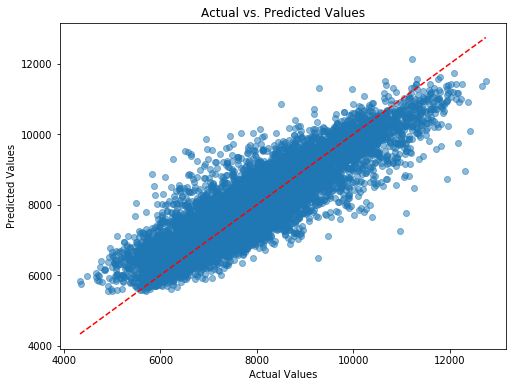

IsWeekend
Mean Squared Error: 250603.26892407096
R-squared: 0.840821141061484


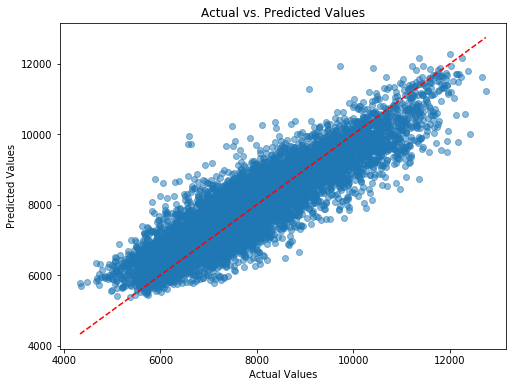

ValueError: If using all scalar values, you must pass an index

In [42]:
## Run to retrieve the One-Drop Out Signal Research

results = {}
for drop_features in list(df.keys()):
    print(drop_features)
    r2 = run_xdg_model(df, 'TOTALDEMAND', To_Z_Score, exclude_features=[drop_features], n_estimators=3000, max_depth=12)
    results[drop_features] = r2

results2 = pd.DataFrame(results)

In [43]:
results

{'TOTALDEMAND': 0.840821141061484,
 'Demand_Previous': 0.7871359335596474,
 'Demand_Lagged': 0.7873560383727735,
 'Demand_Rolling': 0.8096646068941539,
 'TEMPERATURE_lagged': 0.8170203192517355,
 'CPI_lagged': 0.844108800255599,
 'Exports_lagged': 0.8292529651041948,
 'GDP_lagged': 0.8392011151421666,
 'Interest_lagged': 0.8365469305267852,
 'Residential_lagged': 0.840821141061484,
 'Commercial_lagged': 0.840821141061484,
 'SolarOutput_lagged': 0.8376663123594262,
 'Unemployment_lagged': 0.8381093036560059,
 'Price_lagged': 0.8374218749858411,
 'CommPrice_lagged': 0.8364181754058713,
 'Rainfall': 0.820813636878785,
 'SolarExposure': 0.8328424461914762,
 'HourOfDay': 0.7417483223102146,
 'DayOfWeek': 0.8210291068527156,
 'DayOfYear': 0.8150873750824766,
 'IsWeekend': 0.840821141061484}

In [44]:
results2 = pd.DataFrame.from_dict(results, orient='index', columns=['R^2'])

In [45]:
results2.to_csv('../data/r2.csv')

In [46]:
results2

,R^2
TOTALDEMAND,0.840821
Demand_Previous,0.787136
Demand_Lagged,0.787356
Demand_Rolling,0.809665
TEMPERATURE_lagged,0.817020
CPI_lagged,0.844109
Exports_lagged,0.829253
GDP_lagged,0.839201
Interest_lagged,0.836547
Residential_lagged,0.840821
